In [1]:
!nvidia-smi

Sat Sep 25 08:30:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.118.02   Driver Version: 440.118.02   CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:51:00.0 Off |                  N/A |
|  0%   31C    P8     9W / 250W |  11173MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:CB:00.0 Off |                  N/A |
|  0%   33C    P8     9W / 250W |  11128MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import pandas as pd
import numpy as np

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time  
import torch
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm.notebook import tqdm
import datetime

In [3]:
device= torch.device('cuda:2')

In [4]:
df= pd.read_csv('data/training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1')

In [5]:
df= df.dropna(axis=1)

In [6]:
df= df[(~(df['essay_set']==8)) & (~(df['essay_set']==7)) & (~(df['essay_set']==1)) & (~(df['essay_set']==2))]

In [7]:
df

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score
3583,5978,3,The features of the setting affect the cyclist...,1,1,1
3584,5979,3,The features of the setting affected the cycli...,2,2,2
3585,5980,3,Everyone travels to unfamiliar places. Sometim...,1,1,1
3586,5981,3,I believe the features of the cyclist affected...,1,1,1
3587,5982,3,The setting effects the cyclist because of the...,2,2,2
...,...,...,...,...,...,...
10679,16629,6,The one obstacle the builders had when trying ...,2,0,0
10680,16630,6,Some of the problems with the constructing of ...,1,2,2
10681,16631,6,The builders of the Empire State building face...,2,3,3
10682,16632,6,The obstacles the builders of the Empire State...,2,1,2


# Normalization

In [8]:
# def normalize(x, mini, maxi):
#     x['domain1_score']= int((x['domain1_score']-mini)/(maxi-mini) * 100)
#     return x

In [9]:
# for i in tqdm(range(1, 8)):
#     tmp= df[(df['essay_set']==i)]['domain1_score'].copy()
#     mini= min(tmp)
#     maxi= max(tmp)
#     df[(df['essay_set']==i)]= df[(df['essay_set']==i)].apply(lambda x: normalize(x, mini, maxi), axis=1)
    

<AxesSubplot:>

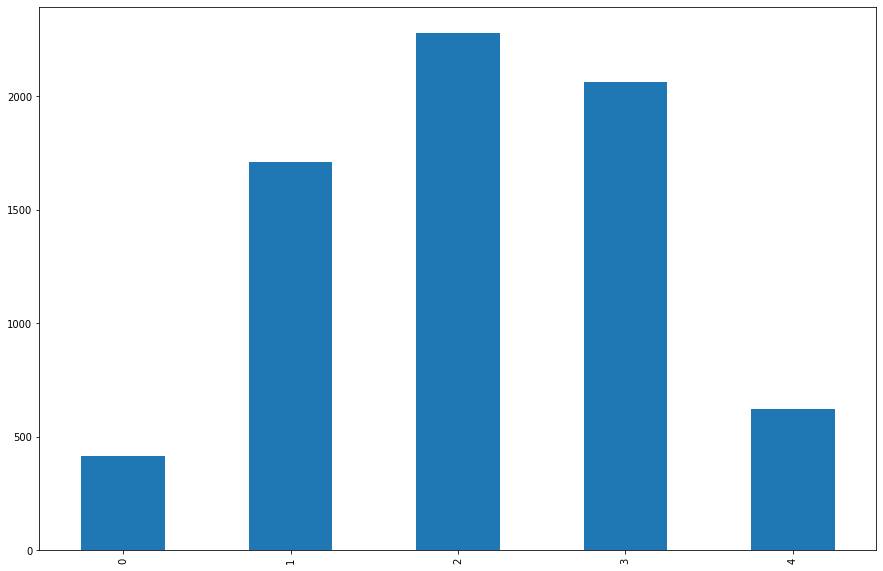

In [10]:
counts= df['domain1_score'].value_counts()
counts.plot(kind='bar', figsize=(15, 10))

In [11]:
df.columns

Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'domain1_score'],
      dtype='object')

In [12]:
df= df.drop(['essay_set', 'essay_id'], axis=1)
# df= df.drop(['rater1_domain1', 'rater2_domain1'], axis=1)

In [13]:
df

,essay,rater1_domain1,rater2_domain1,domain1_score
3583,The features of the setting affect the cyclist...,1,1,1
3584,The features of the setting affected the cycli...,2,2,2
3585,Everyone travels to unfamiliar places. Sometim...,1,1,1
3586,I believe the features of the cyclist affected...,1,1,1
3587,The setting effects the cyclist because of the...,2,2,2
...,...,...,...,...
10679,The one obstacle the builders had when trying ...,2,0,0
10680,Some of the problems with the constructing of ...,1,2,2
10681,The builders of the Empire State building face...,2,3,3
10682,The obstacles the builders of the Empire State...,2,1,2


In [14]:
# tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [15]:
df['essay'] = df['essay'].apply(lambda x: " ".join(x.split()[:512]))

In [16]:
train_df, val_df = train_test_split(df, test_size=0.25, shuffle=True)
train_df.shape, val_df.shape

((5325, 4), (1776, 4))

In [17]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [18]:
class AESDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        sample = self.df.iloc[index]

        inputs= self.tokenizer.encode_plus(sample['essay'],
                          add_special_tokens=True,
                          max_length=self.max_len,
                          padding='max_length',
                          truncation=True,
                          return_token_type_ids=True)
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        ids= torch.tensor(ids, dtype=torch.long),
        mask= torch.tensor(mask, dtype=torch.long),
        token_type_ids= torch.tensor(token_type_ids, dtype=torch.long),
        targets= torch.tensor(sample['domain1_score'], dtype=torch.float)
        
        return (ids, mask, token_type_ids, targets)

In [19]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8

In [20]:
train_dataset = AESDataset(train_df, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size= TRAIN_BATCH_SIZE, shuffle=True, num_workers= 4)

In [21]:
val_dataset = AESDataset(val_df, tokenizer, MAX_LEN)
val_loader = DataLoader(val_dataset, batch_size = VALID_BATCH_SIZE, shuffle=True, num_workers= 4)

In [22]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.base_model = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 256)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(256, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = F.log_softmax(output, dim=1)
        return output

In [23]:
model = Model()
model = model.to(device)

In [24]:
LOSS_FUN= torch.nn.CrossEntropyLoss() #torch.nn.MSELoss()

In [25]:
def train(model, optimizer, loss_fun,
          train_loader, val_loader, 
          scheduler=None, 
          num_epochs=5,batch_size=16, 
          device=device, 
          train_whole_model=False, 
          save_as="model.pkl"):
    
    step = 0
    # if we want to train all the model (our added layers + RoBERTa)
    if train_whole_model:
        for param in model.base_model.parameters():
            param.requires_grad = True
    # in case we just want to train our added layer.
    else:
        for param in model.base_model.parameters():
            param.requires_grad = False

    model.train()
    min_val = float('inf')
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        batch_count = 0
        model.train()
        for (input_ids, input_mask, token_type_ids, y_true) in tqdm(train_loader):
            input_ids=input_ids[0].to(device)
            attention_mask=input_mask[0].to(device)
            token_type_ids= token_type_ids[0].to(device)
            y_pred= model(input_ids, attention_mask, token_type_ids).squeeze(1)
            loss = loss_fun(y_pred, y_true.long().to(device))
            loss.backward()
            # Optimizer and scheduler step
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            # Update train loss and step
            train_loss += loss.item()
            step += batch_size
            batch_count += 1
        
        train_loss /= batch_count
        model.eval()
        with torch.no_grad():
            batch_count = 0
            for (input_ids, input_mask, token_type_ids, y_true) in tqdm(val_loader):
                input_ids=input_ids[0].to(device)
                attention_mask=input_mask[0].to(device)
                token_type_ids= token_type_ids[0].to(device)
                y_pred= model(input_ids, attention_mask, token_type_ids).squeeze(1)
                loss = loss_fun(y_pred, y_true.long().to(device))
                val_loss += loss.item()
                batch_count += 1
            val_loss /= batch_count
        
        if val_loss < min_val:
            min_val= val_loss
            torch.save({'state_dict': model.state_dict()}, 'model.tar')
            print(f"Updating Model at Epoch: {epoch}")
        print(f"{datetime.datetime.now().time()} Epoch: {epoch}/{num_epochs}: train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")

In [26]:
# Main training loop
NUM_EPOCHS_1 = 6
steps_per_epoch = len(train_loader)

print(" ............. Training the added Layers only ............. ")
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer,  num_warmup_steps=steps_per_epoch*1, num_training_steps=steps_per_epoch*NUM_EPOCHS_1)
train(model=model, 
      train_loader=train_loader, val_loader=val_loader, 
      optimizer=optimizer, scheduler=scheduler, 
      loss_fun = LOSS_FUN,
      num_epochs=NUM_EPOCHS_1, train_whole_model = False)


print(" ............. Training the whole Model ............. ")
NUM_EPOCHS_2 = 18
optimizer = AdamW(model.parameters(), lr=1e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=steps_per_epoch*2, num_training_steps=steps_per_epoch*NUM_EPOCHS_2)

train(model=model,  
      train_loader=train_loader,  val_loader=val_loader,  
      optimizer=optimizer, scheduler=scheduler,
      loss_fun = LOSS_FUN,
      num_epochs=NUM_EPOCHS_2, train_whole_model=True)

 ............. Training the added Layers only ............. 


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 0
08:32:51.682663 Epoch: 0/6: train_loss: 1.4939, val_loss: 1.4530


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 1
08:35:05.232216 Epoch: 1/6: train_loss: 1.3967, val_loss: 1.3813


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 2
08:37:19.216565 Epoch: 2/6: train_loss: 1.3365, val_loss: 1.3260


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 3
08:39:32.806451 Epoch: 3/6: train_loss: 1.2928, val_loss: 1.2908


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 4
08:41:46.513436 Epoch: 4/6: train_loss: 1.2738, val_loss: 1.2718


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 5
08:44:00.103919 Epoch: 5/6: train_loss: 1.2655, val_loss: 1.2665
 ............. Training the whole Model ............. 


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 0
08:49:26.964533 Epoch: 0/18: train_loss: 1.2206, val_loss: 1.1504


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 1
08:54:54.589592 Epoch: 1/18: train_loss: 1.0702, val_loss: 0.9455


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 2
09:00:21.403283 Epoch: 2/18: train_loss: 0.9290, val_loss: 0.8726


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 3
09:05:48.168685 Epoch: 3/18: train_loss: 0.8722, val_loss: 0.8362


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 4
09:11:14.494472 Epoch: 4/18: train_loss: 0.8116, val_loss: 0.8070


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 5
09:16:40.414554 Epoch: 5/18: train_loss: 0.7805, val_loss: 0.7808


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 6
09:22:07.877927 Epoch: 6/18: train_loss: 0.7470, val_loss: 0.7674


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 7
09:27:35.541179 Epoch: 7/18: train_loss: 0.7231, val_loss: 0.7603


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

09:33:02.349488 Epoch: 8/18: train_loss: 0.7086, val_loss: 0.7741


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 9
09:38:30.412662 Epoch: 9/18: train_loss: 0.6912, val_loss: 0.7476


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 10
09:43:57.612058 Epoch: 10/18: train_loss: 0.6625, val_loss: 0.7466


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 11
09:49:24.388799 Epoch: 11/18: train_loss: 0.6593, val_loss: 0.7377


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 12
09:54:50.202585 Epoch: 12/18: train_loss: 0.6411, val_loss: 0.7359


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

10:00:15.856763 Epoch: 13/18: train_loss: 0.6352, val_loss: 0.7389


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

10:05:41.285777 Epoch: 14/18: train_loss: 0.6271, val_loss: 0.7369


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Updating Model at Epoch: 15
10:11:07.930041 Epoch: 15/18: train_loss: 0.6289, val_loss: 0.7353


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

10:16:33.021849 Epoch: 16/18: train_loss: 0.6153, val_loss: 0.7358


  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

10:21:58.939311 Epoch: 17/18: train_loss: 0.6207, val_loss: 0.7366


In [27]:
d = []
y_preds = []
y_trues = []
for i in tqdm(range(len(val_dataset))):
    input_ids, input_mask, token_type_ids, y_true = val_dataset[i]
    input_ids= input_ids[0].unsqueeze(0).to(device)
    input_mask= input_mask[0].unsqueeze(0).to(device)
    token_type_ids= token_type_ids[0].unsqueeze(0).to(device)

    y_pred = model(input_ids, input_mask, token_type_ids)
    y_pred = torch.argmax(y_pred) 
    p= int(y_pred.item())
    t= int(y_true.item())
    y_preds.append(p)
    y_trues.append(t)
    d.append(abs(t-p))

  0%|          | 0/1776 [00:00<?, ?it/s]

In [28]:
keys = list(Counter(d).keys())
values = list(Counter(d).values())

In [29]:
t = Counter(d).most_common()

In [30]:
for i in range(len(keys)):
    print(f"There are {t[i][1]} samples with difference equlas to {t[i][0]} betweeb true and predicted values.")

There are 1238 samples with difference equlas to 0 betweeb true and predicted values.
There are 515 samples with difference equlas to 1 betweeb true and predicted values.
There are 21 samples with difference equlas to 2 betweeb true and predicted values.
There are 2 samples with difference equlas to 3 betweeb true and predicted values.


In [31]:
from sklearn.metrics import cohen_kappa_score

In [32]:
cohen_kappa_score(y_preds, y_trues)

0.5941543906207922

In [33]:
set(y_preds), set(y_trues)

({0, 1, 2, 3, 4}, {0, 1, 2, 3, 4})

In [34]:
print(Counter(y_trues))
print(Counter(y_preds))

Counter({3: 536, 2: 523, 1: 430, 4: 173, 0: 114})
Counter({2: 551, 3: 517, 1: 452, 4: 187, 0: 69})


In [36]:
(1238 + 515) / 1776

0.9870495495495496